In [2]:
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import CategoricalParameter
from sagemaker.tuner import HyperparameterTuner
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.analytics import HyperparameterTuningJobAnalytics

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [4]:
xgboost_container = sagemaker.image_uris.retrieve(framework='xgboost', region=region, version='latest')

In [5]:
train_data_s3_uri = 's3://{}/data/train/train/'.format(bucket)
validation_data_s3_uri = 's3://{}/data/train/validation/'.format(bucket)

In [6]:
s3_input_train_data = TrainingInput(s3_data=train_data_s3_uri, content_type='csv')
s3_input_validation_data = TrainingInput(s3_data=validation_data_s3_uri, content_type='csv')

In [7]:
hyperparameters = {
    'objective': 'binary:logistic',
    'num_round': 50
}

In [8]:
estimator = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.large',
    sagemaker_session=sess
)

In [9]:
hyperparameter_ranges = {
    'num_round': IntegerParameter(1, 1000, scaling_type='Logarithmic'),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Linear'),
    'lambda': ContinuousParameter(0.0001, 1000, scaling_type='Logarithmic')
}

In [10]:
objective_metric_name = 'validation:logloss'

In [11]:
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_type="Minimize",
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=3,
    strategy='Bayesian',
    early_stopping_type='Auto'
)

In [12]:
tuner.fit(
    inputs={
        'train': s3_input_train_data,
        'validation': s3_input_validation_data
    },
    include_cls_metadata=False,
    wait=False
)

In [13]:
tuner.wait()

.............................................................................................................................................................!


In [14]:
hp_results = HyperparameterTuningJobAnalytics(
    sagemaker_session=sess,
    hyperparameter_tuning_job_name=tuner.latest_tuning_job.job_name
)

In [15]:
df_results = hp_results.dataframe()

In [16]:
df_results

,colsample_bytree,lambda,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.548571,0.001584,125.0,xgboost-220401-0353-010-203ca854,Completed,0.412410,2022-04-01 04:04:54+00:00,2022-04-01 04:06:01+00:00,67.0
1,0.509035,0.053001,160.0,xgboost-220401-0353-009-5cf3621e,Failed,NaN,2022-04-01 04:04:44+00:00,2022-04-01 04:06:00+00:00,76.0
2,0.827135,545.459263,867.0,xgboost-220401-0353-008-50472888,Completed,0.413604,2022-04-01 04:01:45+00:00,2022-04-01 04:03:17+00:00,92.0
3,0.530458,104.315301,29.0,xgboost-220401-0353-007-4f69be74,Completed,0.424202,2022-04-01 04:01:42+00:00,2022-04-01 04:02:49+00:00,67.0
4,0.959099,15.746391,139.0,xgboost-220401-0353-006-c3906326,Completed,0.412964,2022-04-01 03:59:46+00:00,2022-04-01 04:00:58+00:00,72.0
5,0.858034,0.090868,416.0,xgboost-220401-0353-005-ab588233,Completed,0.412221,2022-04-01 03:58:19+00:00,2022-04-01 03:59:36+00:00,77.0
6,0.849449,0.017978,701.0,xgboost-220401-0353-004-3c6617e6,Completed,0.412234,2022-04-01 03:58:16+00:00,2022-04-01 03:59:38+00:00,82.0
7,0.835131,0.015604,313.0,xgboost-220401-0353-003-9685c370,Completed,0.412270,2022-04-01 03:55:11+00:00,2022-04-01 03:56:28+00:00,77.0
8,0.828679,0.138972,84.0,xgboost-220401-0353-002-9ca6f2b5,Completed,0.412413,2022-04-01 03:55:02+00:00,2022-04-01 03:57:31+00:00,149.0
9,0.774960,0.000147,1.0,xgboost-220401-0353-001-c695f39f,Completed,0.585070,2022-04-01 03:55:12+00:00,2022-04-01 03:56:22+00:00,70.0


Visualize the change in the objective metric's value. 

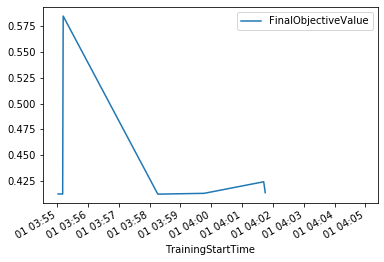

In [31]:
df_results.sort_values('TrainingStartTime').plot(x='TrainingStartTime', y='FinalObjectiveValue')

Examine the hyperparameters of the best performing training job. 

In [18]:
df_results[df_results['FinalObjectiveValue'] == df_results['FinalObjectiveValue'].min()]

,colsample_bytree,lambda,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,0.858034,0.090868,416.0,xgboost-220401-0353-005-ab588233,Completed,0.412221,2022-04-01 03:58:19+00:00,2022-04-01 03:59:36+00:00,77.0


Deploy the best performing model. 

In [19]:
predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m5.large')


2022-04-01 03:59:36 Starting - Preparing the instances for training
2022-04-01 03:59:36 Downloading - Downloading input data
2022-04-01 03:59:36 Training - Training image download completed. Training in progress.
2022-04-01 03:59:36 Uploading - Uploading generated training model
2022-04-01 03:59:36 Completed - Training job completed
-----!